# Practica 3 - TIV

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

from scipy.ndimage import convolve, correlate, uniform_filter, gaussian_filter, median_filter, rotate
from scipy.ndimage import prewitt, sobel, laplace

from skimage import filters
from skimage.data import camera
from skimage.util import random_noise
from skimage import feature, color, data, util, exposure
from skimage.morphology import (square, rectangle, diamond, disk, cube,
                                octahedron, ball, octagon, star,
                                binary_erosion, binary_dilation, binary_opening, binary_closing,
                               remove_small_holes, label, convex_hull_image, skeletonize, thin, reconstruction,
                               opening, closing, dilation, erosion)
from skimage.filters import threshold_otsu

 ### 1) Leer y representar la imagen riceBGgradient.tif 

Formato: TIFF
Dimensiones: (600, 600)
Modo de color: L


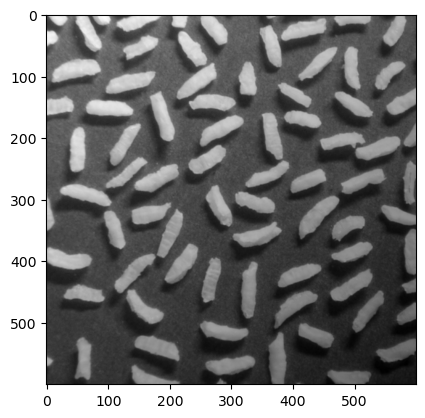

In [29]:
image_path = 'images/riceBGgradient.tif'
img1 = Image.open(image_path)

# Se exploran algunas propiedades de la imagen a procesar
print('Formato:', img1.format)
print('Dimensiones:', img1.size)
print('Modo de color:', img1.mode)

# Visualización de la imagen
plt.figure()
plt.imshow(img1, cmap='gray')

### 2) Intenta separar los granos del fondo estableciendo un umbral 

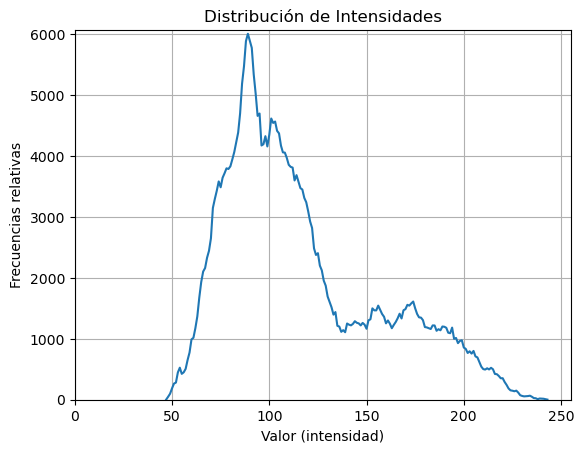

In [30]:
# Convertimos la imagen a un array de NumPy.
image_array = np.array(img1)

# Calculamos y representamos el histograma.
hist_values, hist_bins = exposure.histogram(image_array, normalize=False)
plt.plot(hist_bins, hist_values)
plt.axis([0, 255, 0, 1.01 * hist_values.max()])
plt.title('Distribución de Intensidades')
plt.xlabel('Valor (intensidad)')
plt.ylabel('Frecuencias relativas')
plt.grid()


Observamos que los valores de intensidad en la imagen se encuentran mayormente en el rango de 50 a 250. Utilizando esta información, podemos establecer un umbral mediante la creación de una máscara. Este umbral actuará como un filtro, identificando y preservando los píxeles cuyos valores de intensidad caen dentro de este rango, mientras que los demás serán suprimidos. Este enfoque de umbralización nos permite resaltar características específicas de la imagen basadas en su nivel de intensidad, facilitando la segmentación y destacando áreas de interés.

Text(0.5, 1.0, 'Imagen Segmentada')

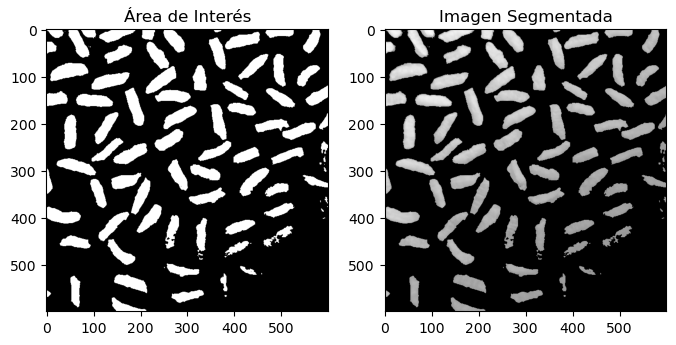

In [31]:
# Definimos los umbrales para la máscara.
threshold_min, threshold_max = 143, 255

# Creamos una máscara utilizando la operación lógica AND.
binary_mask = np.logical_and(image_array > threshold_min, image_array < threshold_max)

# Aplicamos la máscara a la imagen original.
segmented_image = image_array * binary_mask

# Visualización de la máscara y la imagen transformada.
plt.figure(figsize=(8, 8))
plt.subplot(121)
plt.imshow(binary_mask, cmap='gray')
plt.title('Área de Interés')
plt.subplot(122)
plt.imshow(segmented_image, cmap='gray')
plt.title('Imagen Segmentada')


El valor mínimo necesario para que el fondo de la máscara esté completamente cubierto es 140. No obstante, al establecer este valor como umbral, observamos que los granos de arroz en la esquina inferior derecha comienzan a desaparecer. Esto se debe a que, en la imagen original, esta esquina es la más oscura, y al fijar un umbral tan alto, se excluyen los granos de arroz que pertenecen a esa región más oscura.

Como no hemos conseguido lo que queremos teniendo en cuenta los valores del histograma, voy a intentar hacer otras pruebas con diferentes umbrales a ver si consigo sacar un mejor resultado.

In [32]:
# Seleccionamos los umbrales para crear la máscara que extraerá los granos de arroz.
threshold_1, threshold_2 = 50, 175

# Creamos la máscara mediante la operación lógica NOT y AND.
rice_mask = np.logical_not(np.logical_and(image_array[:, :] >= threshold_1, image_array[:, :] <= threshold_2))


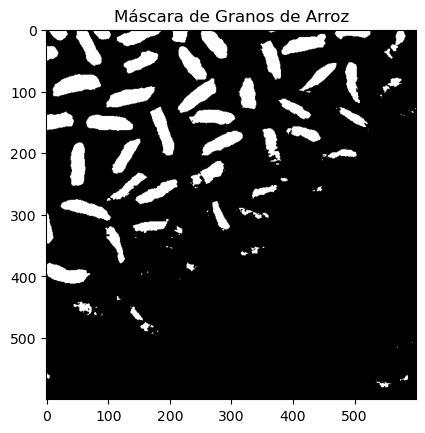

In [33]:
# Visualización de la máscara.
plt.imshow(rice_mask, cmap='gray')
plt.title('Máscara de Granos de Arroz')
plt.show()

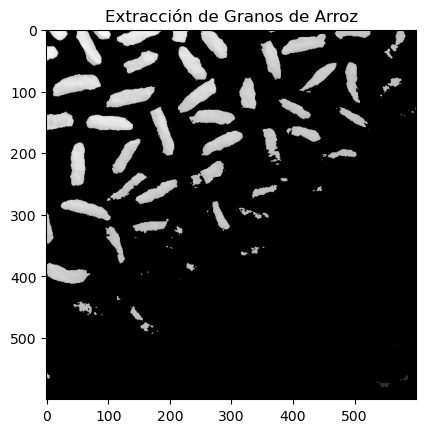

In [34]:
# Multiplicación de la máscara con la imagen original para extraer los granos.
rice_extracted_image = np.multiply(image_array, rice_mask)

# Visualización de la imagen con los granos de arroz resaltados.
plt.imshow(rice_extracted_image, cmap='gray')
plt.title('Extracción de Granos de Arroz')
plt.show()

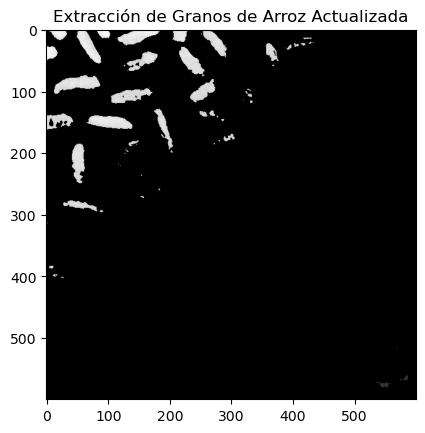

In [35]:
# Seleccionamos los umbrales para crear la máscara que extraerá los granos de arroz.
threshold_1, threshold_2 = 50, 200

# Creamos la máscara mediante la operación lógica NOT y AND.
rice_mask_updated = np.logical_not(np.logical_and(image_array[:, :] >= threshold_1, image_array[:, :] <= threshold_2))

# Multiplicamos la máscara con la imagen original para extraer los granos de arroz.
rice_extracted_image_updated = np.multiply(image_array, rice_mask_updated)

# Visualización de la imagen con los granos de arroz resaltados mediante la nueva máscara.
plt.imshow(rice_extracted_image_updated, cmap='gray')
plt.title('Extracción de Granos de Arroz Actualizada')
plt.show()

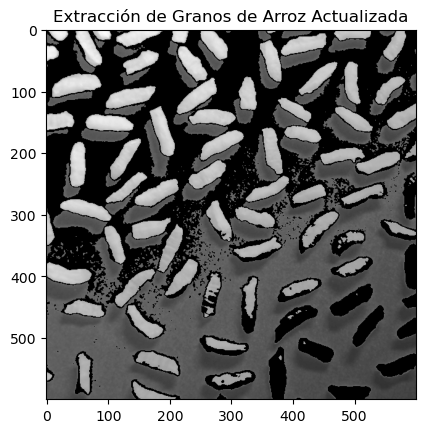

In [36]:
# Seleccionamos los umbrales para crear la máscara que extraerá los granos de arroz.
threshold_1, threshold_2 = 100, 150

# Creamos la máscara mediante la operación lógica NOT y AND.
rice_mask_updated = np.logical_not(np.logical_and(image_array[:, :] >= threshold_1, image_array[:, :] <= threshold_2))

# Multiplicamos la máscara con la imagen original para extraer los granos de arroz.
rice_extracted_image_updated = np.multiply(image_array, rice_mask_updated)

# Visualización de la imagen con los granos de arroz resaltados mediante la nueva máscara.
plt.imshow(rice_extracted_image_updated, cmap='gray')
plt.title('Extracción de Granos de Arroz Actualizada')
plt.show()


Dado que la imagen no presenta homogeneidad en términos de intensidad, surge la necesidad de igualar el valor de intensidad del fondo para poder aplicar una máscara de manera efectiva. Este proceso de igualación de intensidad busca nivelar las diferencias de luminosidad en la imagen, permitiendo una aplicación más precisa de la máscara y preservando los detalles, incluso en regiones de la imagen que originalmente podrían haber sido afectadas por un umbral alto.

### 3) Como habrás visto, no es posible obtener un resultado satisfactorio debido a la inhomogeneidad en la iluminación. Utiliza una transformación morfológica top-hat para corregir la iluminación, tal y como se ha hecho en clase 

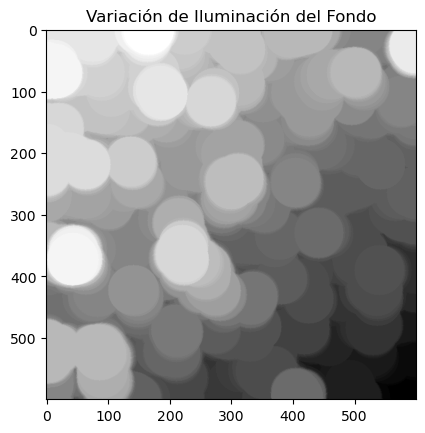

In [37]:
# Estimamos la variación de iluminación del fondo mediante una apertura.
background_variation = opening(image_array, disk(40))  # Apertura con un elemento estructurante circular de radio 40.
plt.imshow(background_variation, cmap='gray')
plt.title('Variación de Iluminación del Fondo')
plt.show()

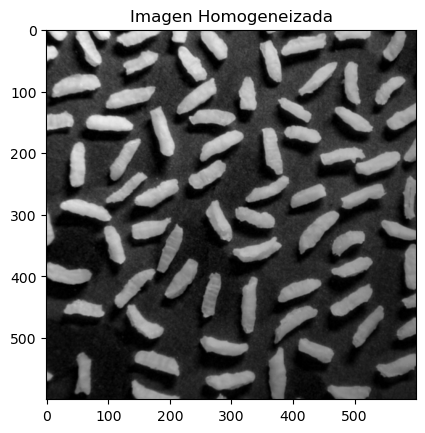

In [38]:
# Visualización de la homogeneización mediante la resta entre la imagen original y la variación de iluminación del fondo.
homogenized_image = image_array - background_variation
plt.imshow(homogenized_image, cmap='gray')
plt.title('Imagen Homogeneizada')
plt.show()

### 4) Busca ahora un umbral. Para buscar el umbral, puedes ayudarte con la función  “skimage.filters.threshold_otsu” 


La estrategia adoptada para emplear la función threshold_otsu se fundamenta en la búsqueda de información sobre esta función en la documentación de skimage. A través de un ejemplo proporcionado en la web de skimage, se brinda una comprensión clara y precisa de cómo utilizar esta función. Este enfoque de aprendizaje mediante ejemplos facilita la correcta implementación de threshold_otsu, permitiendo aprovechar las capacidades de umbralización automática que ofrece la función en el procesamiento de imágenes.

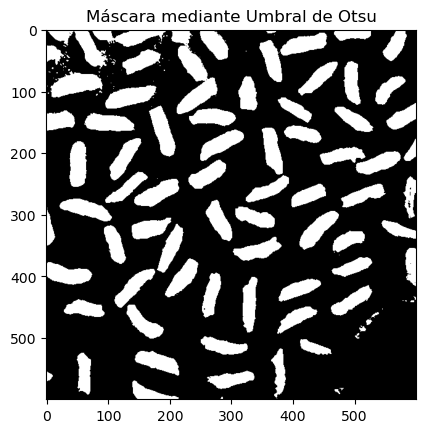

In [39]:
# Calculamos el umbral utilizando la función de Otsu.
otsu_threshold = threshold_otsu(image_array)

# Creamos una máscara utilizando el umbral calculado.
binary_mask_otsu = np.logical_not(image_array <= otsu_threshold)

# Visualización de la máscara generada por el umbral de Otsu.
plt.imshow(binary_mask_otsu, cmap='gray')
plt.title('Máscara mediante Umbral de Otsu')
plt.show()

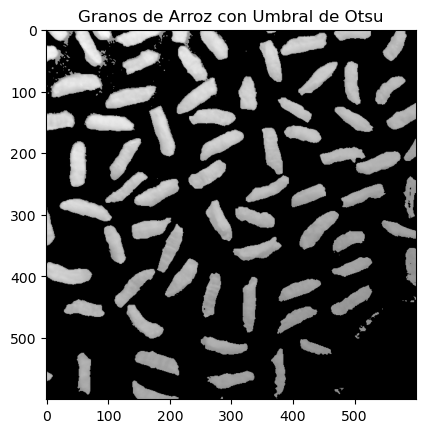

El umbral calculado por la función de Otsu es: 134


In [41]:
# Multiplicamos la máscara con la imagen original para extraer los granos de arroz.
rice_extracted_otsu = np.multiply(image_array, binary_mask_otsu)

# Visualización de la imagen con los granos de arroz resaltados mediante el umbral de Otsu.
plt.imshow(rice_extracted_otsu, cmap='gray')
plt.title('Granos de Arroz con Umbral de Otsu')
plt.show()

# Mostramos el valor del umbral calculado por la función de Otsu.
print('El umbral calculado por la función de Otsu es:', otsu_threshold)


Como se evidencia, la aplicación de este valor de umbral a la imagen homogeneizada ha producido un resultado considerablemente satisfactorio. Este umbral ha logrado extraer casi en su totalidad todos los granos de arroz, resaltando de manera efectiva los detalles relevantes de la imagen. Este éxito en la segmentación subraya la eficacia del umbral seleccionado y demuestra cómo el proceso de homogeneización previo ha mejorado la capacidad de la imagen para responder a la umbralización, facilitando la identificación y extracción de los elementos de interés, en este caso, los granos de arroz.